## Prepare imports

In [1]:
import torch
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from models.vae_mnist import VanillaVAE
from models.vae_mnist import BaseModel as BaseVAE
from datasets.modelnet import ModelNetDataModule, ModelNetDataModuleConfig
from models.ectencoder_mnist import BaseModel as EctEncoder
from layers.ect import EctLayer, EctConfig

from metrics.metrics import get_mse_metrics
from metrics.accuracies import compute_mse_accuracies
from metrics.loss import compute_mse_loss_fn
from directions import generate_3d_directions


DEVICE = "cuda:0"


config = OmegaConf.load("./configs/config_encoder_modelnet.yaml")

## Load Models and Data

In [2]:


layer = EctLayer(
    EctConfig(
        num_thetas=config.layer.ect_size,
        bump_steps=config.layer.ect_size,
        normalized=True,
        device=DEVICE,
    ),
    v=generate_3d_directions(config.layer.ect_size, DEVICE),
)

dm = ModelNetDataModule(
    ModelNetDataModuleConfig(name="10", samplepoints=config.data.samplepoints)
)

vae_model = VanillaVAE(in_channels=1, latent_dim=64,img_size=config.layer.ect_size)

# Load the VAE model

metrics = get_mse_metrics()

vae_litmodel = BaseVAE.load_from_checkpoint(
    "./trained_models/vae_modelnet.ckpt",
    model=vae_model,
    training_accuracy=metrics[0],
    test_accuracy=metrics[1],
    validation_accuracy=metrics[2],
    accuracies_fn=compute_mse_accuracies,
    loss_fn=compute_mse_loss_fn,
    learning_rate=0.01,
    layer=layer,
).to(DEVICE)


# Load the encoder 

ect_encoder_litmodel = EctEncoder.load_from_checkpoint(
    f"./trained_models/ectencoder_3d_final.ckpt",
    layer=layer,
    ect_size=config.layer.ect_size,
    hidden_size=config.encodermodel.hidden_size,
    num_pts=config.encodermodel.num_pts,
    num_dims=config.encodermodel.num_dims,
    learning_rate=config.encodermodel.learning_rate,
).to(DEVICE)


## Generate an ECT and use VAE as autoencoder to recreate the ECT

In [3]:
data_loader = dm.val_dataloader()
for batch_idx, features in enumerate(data_loader):
    break

features.to(DEVICE)
ect = layer(features,features.batch).unsqueeze(1)


with torch.no_grad():
    decoded, theinput, z_mean, z_log_var = vae_litmodel.forward(ect)

# Undo the VAE transform
decoded = (decoded + 1 ) / 2

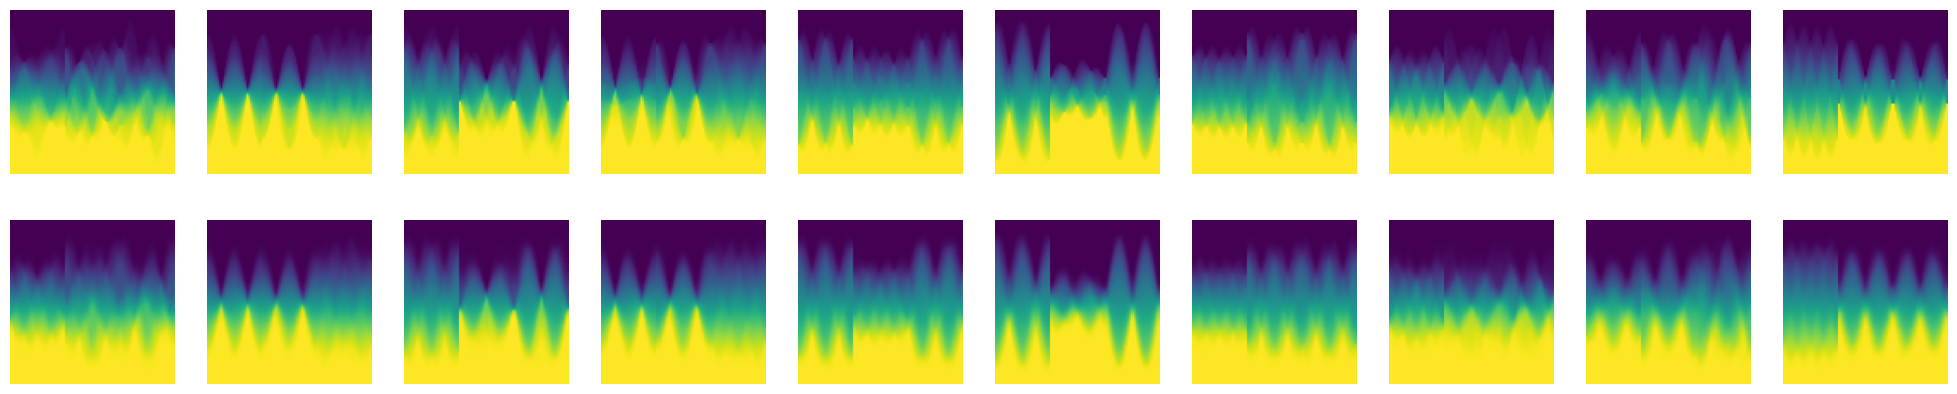

In [5]:
n_images = 10

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(25,5)
)

for orig_img, recon_img,ax in zip(ect,decoded,axes.T):
    ax[0].imshow(orig_img.cpu().detach().squeeze().numpy())
    ax[0].axis("off")
    ax[1].imshow(recon_img.cpu().detach().squeeze().numpy())
    ax[1].axis("off")

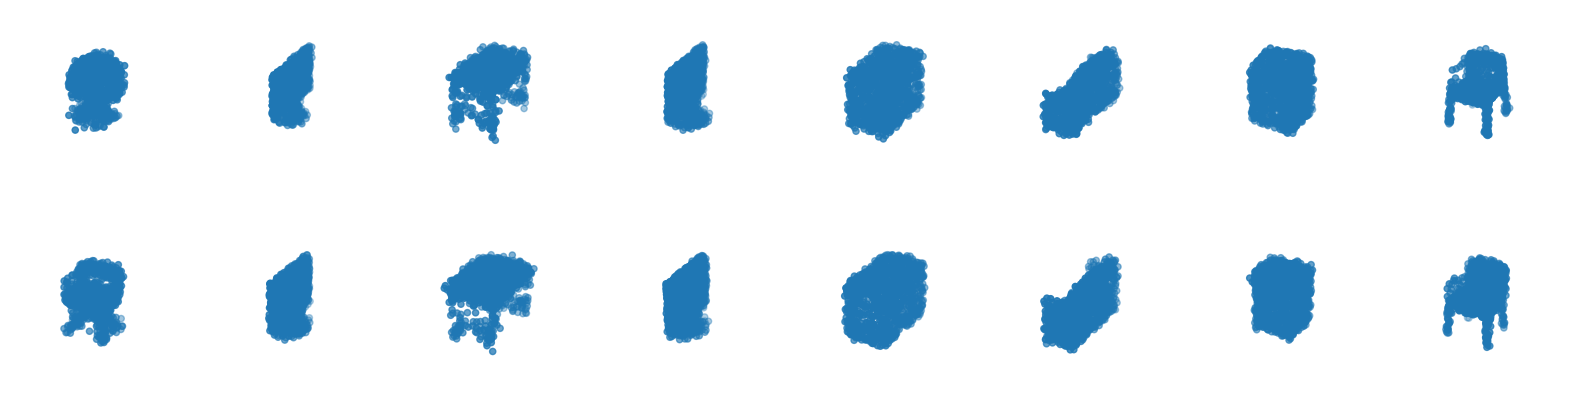

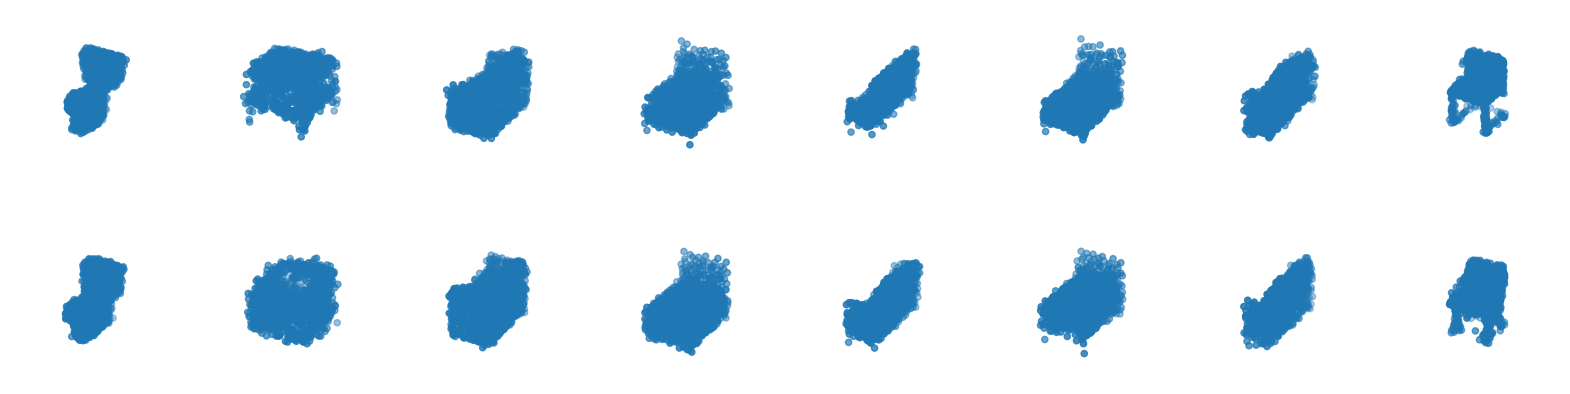

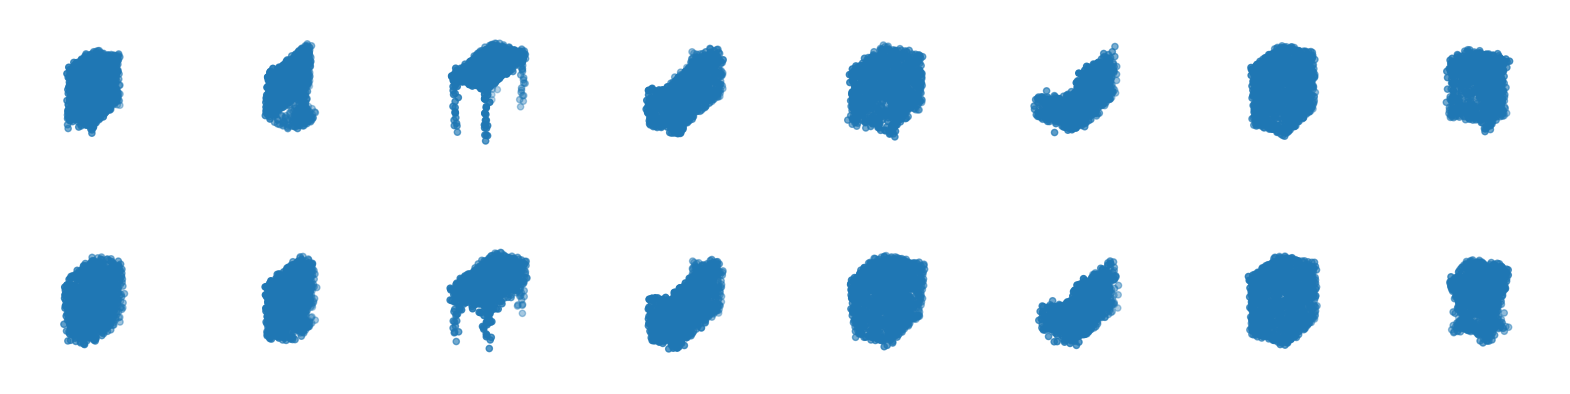

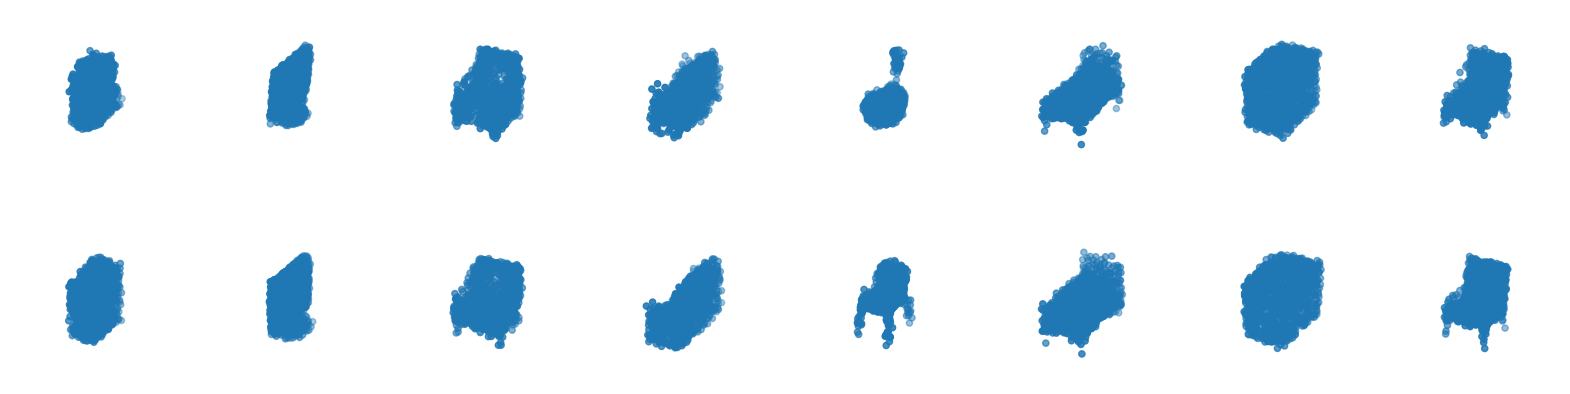

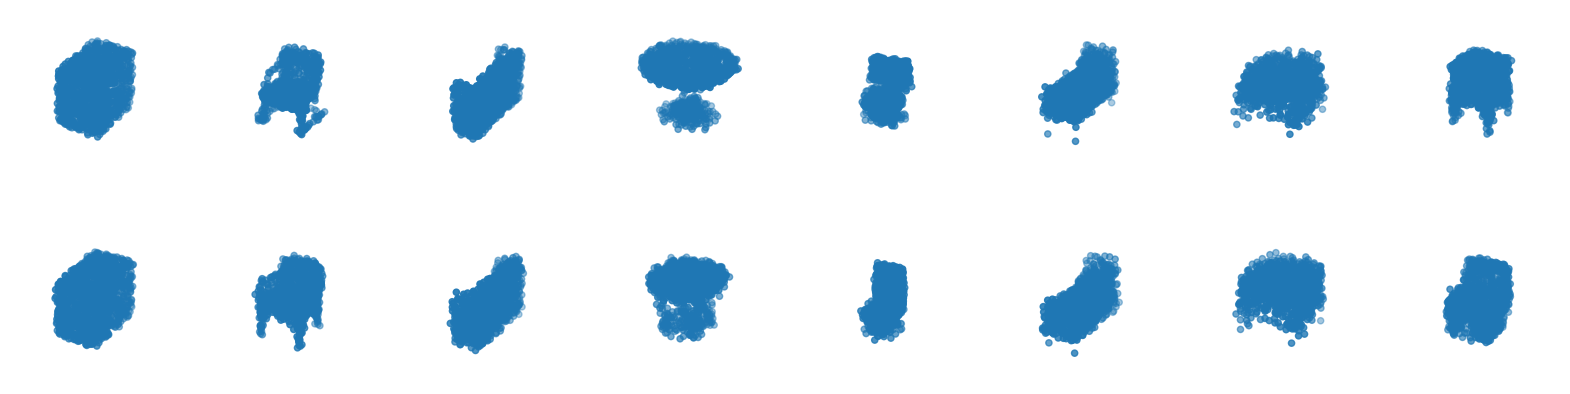

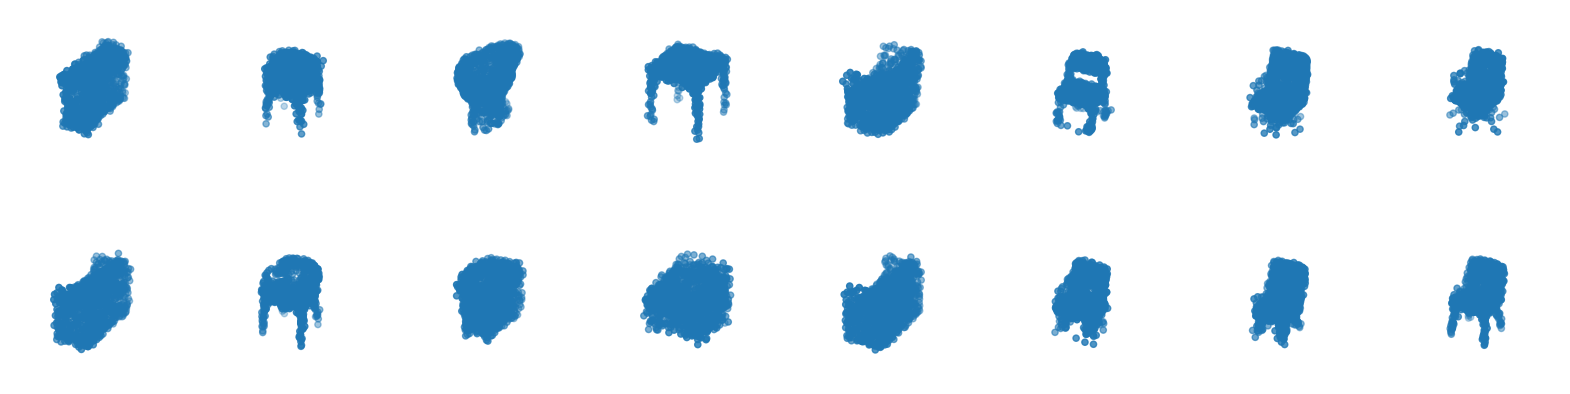

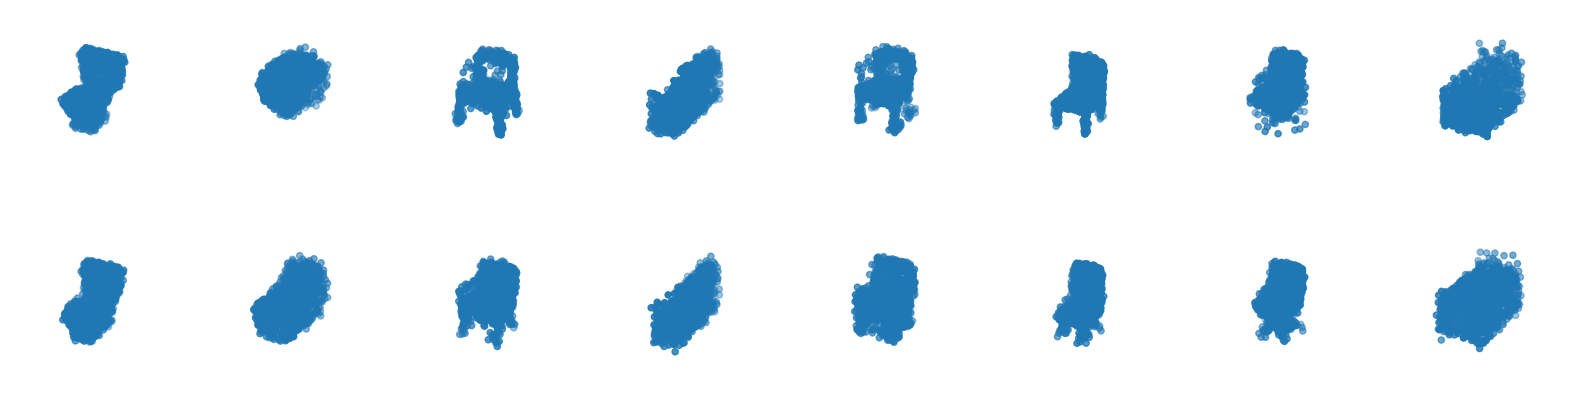

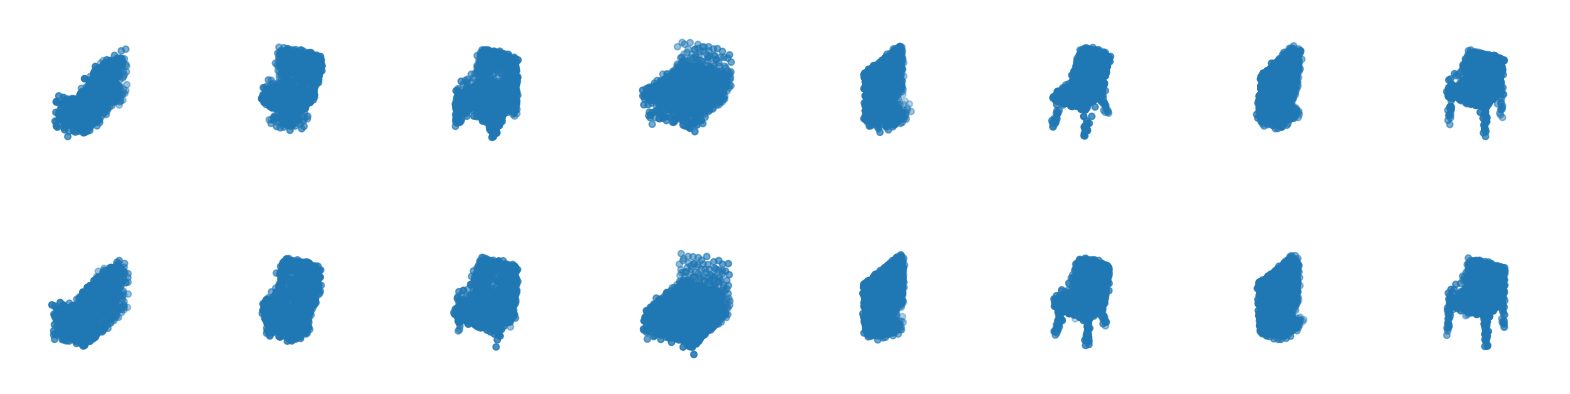

In [7]:
# Pass reconstruction through the point cloud decoder

with torch.no_grad():
    recon_batch = ect_encoder_litmodel.model.forward(ect)
    recon_batch_vae = ect_encoder_litmodel.model.forward(decoded)



n_images = 8

for idx in range(0,64,8):
    fig, axes = plt.subplots(
        nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(20,5),subplot_kw=dict(projection='3d')
    )


    for recon_pts, recon_pts_vae, ax in zip(recon_batch[idx::],recon_batch_vae[idx::],axes.T):
        # print(recon_pts_x.shape)
        recon_pts = recon_pts.view(-1,3).cpu().detach().squeeze().numpy()
        recon_pts_vae = recon_pts_vae.view(-1,3).cpu().detach().squeeze().numpy()


        ax[0].scatter(recon_pts[:,0],recon_pts[:,1],recon_pts[:,2])
        ax[0].set_xlim([-1,1])
        ax[0].set_ylim([-1,1])
        ax[0].axis("off")

        ax[1].scatter(recon_pts_vae[:,0],recon_pts_vae[:,1],recon_pts_vae[:,2])
        ax[1].set_xlim([-1,1])
        ax[1].set_ylim([-1,1])
        ax[1].axis("off")
    

## Sample from VAE and reconstruct points 

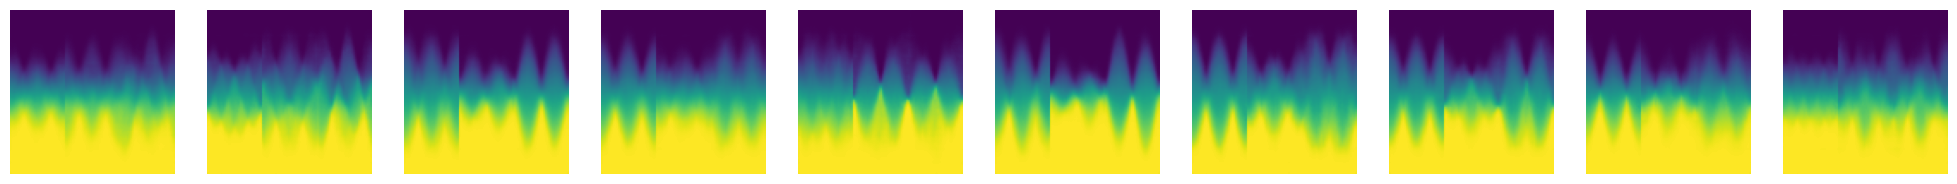

In [9]:
samples = vae_litmodel.model.sample(64, "cuda:0")

n_images = 10

fig, axes = plt.subplots(
    nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(25,5)
)

for sample, ax in zip(samples,axes.T):
    ax.imshow(sample.cpu().detach().squeeze().numpy())
    ax.axis("off")

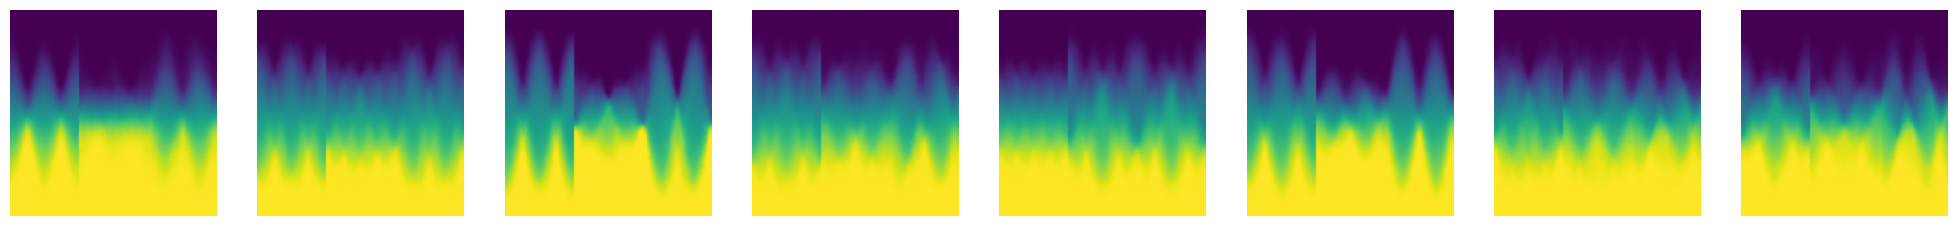

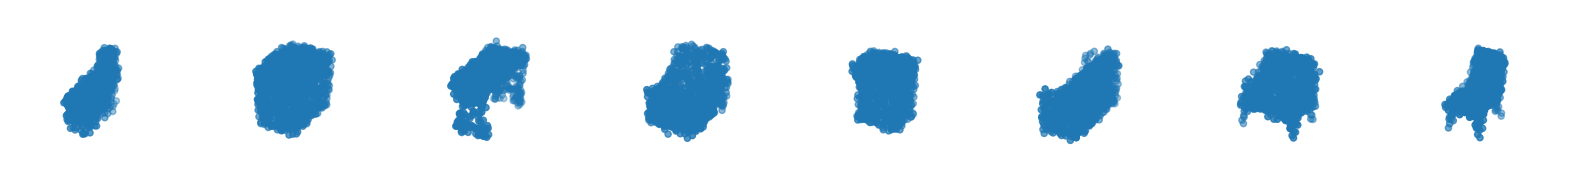

In [10]:
samples = vae_litmodel.model.sample(64, "cuda:0")
samples = (samples + 1) / 2

with torch.no_grad():
    recon_batch_samples = ect_encoder_litmodel.model.forward(samples)


n_images = 8

for idx in range(0,8,8):
    

    fig, axes = plt.subplots(
    nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(25,5)
    )
    for sample, ax in zip(samples[idx::],axes.T):
        ax.imshow(sample.cpu().detach().squeeze().numpy())
        ax.axis("off")

    fig, axes = plt.subplots(
        nrows=1, ncols=n_images, figsize=(20,5),subplot_kw=dict(projection='3d')
    )

    for recon_pts_samples, ax in zip(recon_batch_samples[idx::],axes.T):
        recon_pts_samples = recon_pts_samples.view(-1,3).cpu().detach().squeeze().numpy()


        ax.scatter(recon_pts_samples[:,0],recon_pts_samples[:,1],recon_pts_samples[:,2])
        ax.set_xlim([-1,1])
        ax.set_ylim([-1,1])
        ax.axis("off")

    #     ax[1].imshow(sample.cpu().detach().squeeze().numpy())
    #     ax[1].axis("off")